# Continuous Control Using DDPG
---


### Dependencies

In [1]:
# Shallow and deep copy operations
# Documentation: https://docs.python.org/3/library/copy.html
import copy

# Generate pseudo-random numbers
# Documentation: https://docs.python.org/3/library/random.html
import random

# namedtuple: factory function for creating tuple subclasses with named fields
# deque: list-like container with fast appends and pops on either end
# Documentation: https://docs.python.org/3/library/collections.html
from collections import namedtuple, deque

# Return the time in seconds since the epoch as a floating point number
# Documentation: https://docs.python.org/3/library/time.html#time.time
from time import time

# Basic date and time types
# Documentation: https://docs.python.org/3/library/datetime.html
import datetime

# Unity Machine Learning Agents Environment
# Documentation: https://github.com/Unity-Technologies/ml-agents/tree/master/docs
from unityagents import UnityEnvironment

# torch: Optimized tensor library for deep learning using GPUs and CPUs
# torch.nn: Contains various components for constructing neural networks
# torch.nn.functional: Contains various functions for neural networks
# torch.optim: A package implementing various optimization algorithms
# Documentation: https://pytorch.org/docs/stable/index.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Package for scientific computing with a powerful N-dimensional array object
# Documentation: https://docs.scipy.org/doc/numpy/reference/routines.html
import numpy as np

# Provides a MATLAB-like way of plotting
# Documentation: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html
import matplotlib.pyplot as plt

# Set the backend of matplotlib to the 'inline' backend
%matplotlib inline

### Actor & Critic Classes

In [2]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    # Actor (Policy) Model

    def __init__(self, state_size, action_size, seed, fc_units=256):
        # Parameters are initialized and model is built.
        # state_size (int): Dimension of each state
        # action_size (int): Dimension of each action
        # seed (int): Random seed
        # fc_units (int): Number of nodes in first hidden layer
        
        super(Actor, self).__init__()
        # random seed for pytorch number generators
        self.seed = torch.manual_seed(seed)
        
        # Network layers
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        
        # Layer weights are initialized
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))


class Critic(nn.Module):
    # Critic (Value) Model

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        # Parameters are initialized and model is built.
        # state_size (int): Dimension of each state
        # action_size (int): Dimension of each action
        # seed (int): Random seed
        # fcs1_units (int): Number of nodes in the first hidden layer
        # fc2_units (int): Number of nodes in the second hidden layer
        # fc3_units (int): Number of nodes in the second hidden layer
        
        super(Critic, self).__init__()
        # random seed for pytorch number generators
        self.seed = torch.manual_seed(seed)
        
        # Network layers
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        
        # Layer weights are initialized
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

### Unity Environment

In [4]:
# Set the file_name for the unity environment
file_name= './env/Reacher_Linux/Reacher.x86_64'

# Load the unity environment
env = UnityEnvironment(file_name=file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Variables

In [4]:
# ---------------------------- Computing Device ---------------------------- #
# Use a CUDA GPU for training, if available. Otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# ---------------------------- Environment Variables ---------------------------- #
# brain_name: The name for the environment brain
# brain: The environment brain
# env_info: # The environment is reset and the new environment information is stored
# state: Current environment state
# state_size: The environment state size
# action_size: The action size

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations
state_size = state.shape[1]
action_size = brain.vector_action_space_size
num_agents = len(env_info.agents)



# ---------------------------- RNG Variables ---------------------------- #
# random_seed: The random seed
# seed: Initializes random number generator

random_seed = 10
seed = random.seed(random_seed)



# ---------------------------- Actor Networks ---------------------------- #
# lr_actor: Learning rate for the Actor Optimizer
# actor_local: The Local Actor Network
# actor_target: The Target Actor Network
# actor_optimizer: Optimizer for Actor Network

lr_actor = 1e-4
actor_local = Actor(state_size, action_size, random_seed).to(device)
actor_target = Actor(state_size, action_size, random_seed).to(device)
actor_optimizer = optim.Adam(actor_local.parameters(), lr=lr_actor)



# ---------------------------- Critic Networks ---------------------------- #
# lr_critic: Learning rate for the Critic Optimizer
# w_decay: L2 weight decay for Critic Optimizer
# critic_local: The Local Critic Network
# critic_target: The Target Critic Network
# critic_optimizer: Optimizer for Critic Network

lr_critic = 3e-4
w_decay = 1e-5
critic_local = Critic(state_size, action_size, random_seed).to(device)
critic_target = Critic(state_size, action_size, random_seed).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=lr_critic, weight_decay=w_decay)



# ---------------------------- Ornstein-Uhlenbeck Process Variables ---------------------------- #
# adds time-correlated noise to the actions taken by the policy

noise = 2
mu = 0.0 * np.ones((num_agents, action_size))
theta = 0.15
sigma = 0.2
noise_reduction = 0.9999
noise_state = copy.copy(mu)



# ---------------------------- Replay Memory Variables ---------------------------- #
# buffer_size: The replay memory buffer size
# memory: The memory buffer
# experience: A tuple subclass to store individual experiences

buffer_size = int(1e6)
memory = deque(maxlen=buffer_size)
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])



# ---------------------------- Training Parameters ---------------------------- #
# checkpoint_folder: path to checkpoint files
# batch_size: Minibatch size
# gamma: Reward discount factor
# tau: For soft update of target parameters
# add_noise: Add noise to action space during training
# t_step: Initial time step (for updating every update_every steps)
# update_every: Time step interval for learning from experiences
# target_avg: Average score required to consider environment solved
# n_episodes: Maximum number of episodes to train
# scores_deque: Stores scores from last 100 episodes for calculating current average score
# scores: Stores scores for all episode to plot after training

checkpoint_folder = './checkpoints/'
batch_size = 256
gamma = 0.99
tau = 1e-3
add_noise = True
t_step = 0
update_every = 4
target_avg = 30.0
n_episodes = 2000
scores_deque = deque(maxlen=100)
scores = []

### Watching an Untrained Agent

In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# get the current state
states = env_info.vector_observations

# Agents interact with environment for 150 time steps
for i in range(150):
    states = torch.from_numpy(states).float().to(device)
    
    # actor_local is set to evaluation mode
    actor_local.eval()

    # Gradient calculation is disabled for inference
    with torch.no_grad():
        
        actions = np.zeros((num_agents, action_size))

        for agent_num, state in enumerate(states):
            action = actor_local(state).cpu().data.numpy()
            actions[agent_num, :] = action

    # actor_local is set back to training mode
    actor_local.train()
    
    # Clip the values in action to the range [-1, 1]
    actions = np.clip(actions, -1, 1)
    
    # send the action to the environment
    env_info = env.step(actions)[brain_name]

    # get the next state
    next_states = env_info.vector_observations

    # get the reward
    rewards = env_info.rewards

    # see if episode has finished
    dones = env_info.local_done

    # state is updated for next time step
    states = next_states

    # exit loop if episode finished
    if np.any(dones):
        break

### Training with DDPG

Episode 100	Score: 9.69	Average Score: 3.85
Episode 200	Score: 18.08	Average Score: 13.22
Episode 300	Score: 25.73	Average Score: 19.85
Episode 400	Score: 29.46	Average Score: 25.00
Episode 460	Score: 33.49	Average Score: 30.09
Environment solved in 360 episodes!	Average Score: 30.1

Actor checkpoint saved to checkpoint_actor_2018-12-11_16-55-57.pth
Critic checkpoint saved to checkpoint_critic_2018-12-11_16-55-57.pth

Trained for 1 hours 30 minutes 19 seconds


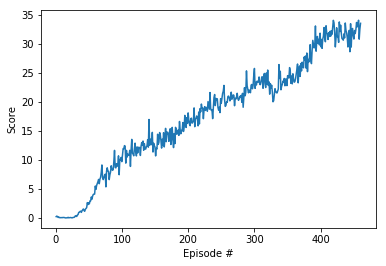

In [6]:
# Time training started
start_time = time()

# Train for n_episodes or until the target_avg score is achieved
for i_episode in range(1, n_episodes+1):
    
    # The starting score for the current episode
    score = 0
    
    # The environment is reset and the new environment information is stored
    env_info = env.reset(train_mode=True)[brain_name]
    
    # The first state observation of the episode
    states = env_info.vector_observations
    
    # ---------------------------- Iterate through episode time steps ---------------------------- #
    while True:
        # ---------------------------- Choose action ---------------------------- #
        # Converts the state observation to a torch.FloatTensor and 
        # moves it to the specified computing device
        states = torch.from_numpy(states).float().to(device)
        
        # actor_local is set to evaluation mode
        actor_local.eval()
        
        # Gradient calculation is disabled for inference
        with torch.no_grad():
            
            actions = np.zeros((num_agents, action_size))
            
            for agent_num, state in enumerate(states):
                action = actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
            
        # actor_local is set back to training mode
        actor_local.train()
        
        # Add noise to the action space
        if add_noise:
            x = noise_state
            dx = theta * (mu - x) + sigma * np.random.standard_normal((num_agents, action_size))
            noise_state = x + dx
            actions += noise*noise_state
            noise *= noise_reduction
        
        # Clip the values in action to the range [-1, 1]
        actions = np.clip(actions, -1, 1)
        
        # ---------------------------- Take action and get new environment info ---------------------------- #
        # Sends all actions to the environment
        env_info = env.step(actions)[brain_name]
        
        # Get next state (for each agent)
        next_states = env_info.vector_observations
        
        # Rewards gained this time step (for each agent)
        rewards = env_info.rewards
        
        # Stores whether episode finished
        dones = env_info.local_done

        # The experience from this time step is saved in the memory buffer
        for i in range(num_agents):
            e = experience(states[i], actions[i], rewards[i], next_states[i], dones[i])
            memory.append(e)
        
        t_step = (t_step + 1) % update_every
        
        # Learning is performed every update_every time steps when enough experiences are available in memory
        if t_step == 0 and len(memory) > batch_size:
            
            # Random sample of experiences from memory buffer
            experiences = random.sample(memory, k=batch_size)
            
            # Parses the Experience Sample:
            # Extracts the states, actions, rewards, next_states, and dones from 
            # the sampled experience tuples into separate lists.  Converts the lists
            # to vertical NumPy arrays.  Converts the NumPy arrays into torch Tensors
            # and moves them to the specified computing device
            
            s_states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
            s_actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
            s_rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
            s_next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
            s_dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

            # Policy and value parameters are updated using the sample of experiences
            # ---------------------------- Critic is Updated ---------------------------- #
            # Predicted next-state actions from target actor
            actions_next = actor_target(s_next_states)
            
            # Q values for next state/action from target critic
            Q_targets_next = critic_target(s_next_states, actions_next)
            
            # Q targets for current state(s)/action(s)
            Q_targets = s_rewards + (gamma * Q_targets_next * (1 - s_dones))
            
            # Expected Q value from local critic
            Q_expected = critic_local(s_states, s_actions)
            
            # The element-wise mean squared error between expected Q value and actual Q value
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            
            # Clears the gradients of all optimized Tensors
            critic_optimizer.zero_grad()
            
            # Computes the gradient
            critic_loss.backward()
            
            # Clips the gradient for critic_local
            torch.nn.utils.clip_grad_norm_(critic_local.parameters(), 1)
            
            # Performs a single optimization step to improve the local critic's expected Q value prediction
            critic_optimizer.step()

            # ---------------------------- Actor is Updated ---------------------------- #
            # The predicted current-state actions from local actor
            actions_pred = actor_local(s_states)
            
            # Actor loss
            actor_loss = -critic_local(s_states, actions_pred).mean()
            
            # Clears the gradients of all optimized Tensors
            actor_optimizer.zero_grad()
            
            # Computes the gradient
            actor_loss.backward()
            
            # Performs a single optimization step to minimize actor loss
            actor_optimizer.step()

            # ----------------------- Soft updates on target networks ----------------------- #
            for target_param, local_param in zip(critic_target.parameters(), critic_local.parameters()):
                # θ_target = τ*θ_local + (1 - τ)*θ_target
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            for target_param, local_param in zip(actor_target.parameters(), actor_local.parameters()):
                # θ_target = τ*θ_local + (1 - τ)*θ_target
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        # state is updated for next time step
        states = next_states
        
        # episode score is updated
        score += np.mean(rewards)
        
        # Check if episode has ended
        if np.any(dones):
            break
    
    scores_deque.append(score)
    scores.append(score)
    
    print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
    
    # Save checkpoints every 100 episodes
    if i_episode % 100 == 0:
        torch.save(actor_local.state_dict(), checkpoint_folder + 'checkpoint_actor.pth')
        torch.save(critic_local.state_dict(), checkpoint_folder + 'checkpoint_critic.pth')
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))

    # If the target average score has been achieved, the model checkpoints are saved
    # with timestamps and the training loop is exited
    if np.average(scores_deque)>=target_avg:
        timestamp = '{:%Y-%m-%d_%H-%M-%S}'.format(datetime.datetime.now())
        actor_checkpoint_name = "checkpoint_actor_{}.pth".format(timestamp)
        critic_checkpoint_name = "checkpoint_critic_{}.pth".format(timestamp)
        
        torch.save(actor_local.state_dict(), checkpoint_folder + actor_checkpoint_name)
        torch.save(critic_local.state_dict(), checkpoint_folder + critic_checkpoint_name)
        
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.1f}'.format(i_episode-100, np.mean(scores_deque)))
        print("\nActor checkpoint saved to {}".format(actor_checkpoint_name))
        print("Critic checkpoint saved to {}".format(critic_checkpoint_name))
        break

# Time training ended
end_time = time()

# Stores training time
tot_time = end_time - start_time
print("\nTrained for", int((tot_time / 3600)), "hours", int(((tot_time % 3600) / 60)), "minutes", 
      int(((tot_time % 3600) % 60)), "seconds")


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### (Optional) Load Model Weights from a Previous Training Session

In [6]:
# The checkpoint file names
actor_checkpoint = checkpoint_folder + 'checkpoint_actor_2018-12-11_16-55-57.pth'
critic_checkpoint = checkpoint_folder + 'checkpoint_critic_2018-12-11_16-55-57.pth'

# Checkpoints weights are loaded into the models
actor_local.load_state_dict(torch.load(actor_checkpoint))
critic_local.load_state_dict(torch.load(critic_checkpoint))

### Watching a Trained Agent

In [7]:
# Total points from all episodes
total_score = 0

# Number of episodes for agent to interact with environment
num_episodes = 3

# Starting time for generating timestamps for each episode
base_time = time()

# Agent will interact with environment for specified number of episodes
for i in range(num_episodes):
    
    # Beginning of episode timestamp
    start_time = time()
    
    # Time passed since the beginning of first episode
    tot_time = start_time - base_time
    time_stamp = "{}:{}:{}".format(int((tot_time / 3600)), int(((tot_time % 3600) / 60)), int(((tot_time % 3600) % 60)))
    
    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]

    # get the current state
    states = env_info.vector_observations
    
    # The starting score for the current episode
    score = 0

    # Agents interact with environment for 150 time steps
    while True:
        states = torch.from_numpy(states).float().to(device)

        # actor_local is set to evaluation mode
        actor_local.eval()

        # Gradient calculation is disabled for inference
        with torch.no_grad():
            
            # Get action Tensor
            # Move action Tensor to CPU and convert to NumPy array
            actions = np.zeros((num_agents, action_size))

            for agent_num, state in enumerate(states):
                action = actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action

        # actor_local is set back to training mode
        actor_local.train()

        # Clip the values in action to the range [-1, 1]
        actions = np.clip(actions, -1, 1)

        # send the action to the environment
        env_info = env.step(actions)[brain_name]

        # get the next state
        next_states = env_info.vector_observations

        # get the reward
        rewards = env_info.rewards

        # see if episode has finished
        dones = env_info.local_done

        # state is updated for next time step
        states = next_states
        
        # episode score is updated
        score += np.mean(rewards)

        # exit loop if episode finished
        if np.any(dones):
            break
    
    total_score += score
    print("Score: {:.2f}, Timestamp: {}".format(score, time_stamp))

print("Average Score: {:.2f}".format(total_score/num_episodes))

Score: 33.25, Timestamp: 0:0:0
Score: 32.79, Timestamp: 0:1:20
Score: 33.79, Timestamp: 0:2:40
Average Score: 33.27


In [7]:
env.close()